In [1]:
!pip install -q transformers datasets sentencepiece
!pip install polyleven
!pip install -q pytorch-lightning wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.or

In [2]:
import os
import re
import json
from collections import Counter
from itertools import chain
from pathlib import Path
from typing import List, Dict, Union, Tuple, Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader
from transformers import (
    DonutProcessor,
    VisionEncoderDecoderConfig,
    VisionEncoderDecoderModel,
    get_scheduler
)
from datasets import Dataset
from datasets import Image as ds_img
from polyleven import levenshtein # a faster version of levenshtein

In [3]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import matplotlib.pyplot as plt
import pandas as pd
import random
import shutil


from glob import glob
from tqdm import tqdm

random.seed(108)

**Mounted Drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip /content/drive/MyDrive/miniProject/benetech-making-graphs-accessible.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/images/eaed09039206.jpg  
  inflating: dataset/train/images/eaed1e245167.jpg  
  inflating: dataset/train/images/eaedb251e670.jpg  
  inflating: dataset/train/images/eaeead418936.jpg  
  inflating: dataset/train/images/eaeeb1c2ecdd.jpg  
  inflating: dataset/train/images/eaef70ba842d.jpg  
  inflating: dataset/train/images/eaf036991cb3.jpg  
  inflating: dataset/train/images/eaf06e9e07db.jpg  
  inflating: dataset/train/images/eaf20f7d8945.jpg  
  inflating: dataset/train/images/eaf3a9a87868.jpg  
  inflating: dataset/train/images/eaf3d05d20a6.jpg  
  inflating: dataset/train/images/eaf3d24fb032.jpg  
  inflating: dataset/train/images/eaf3f734b5ce.jpg  
  inflating: dataset/train/images/eaf467f871a2.jpg  
  inflating: dataset/train/images/eaf65b4e3c45.jpg  
  inflating: dataset/train/images/eaf7f876411a.jpg  
  inflating: dataset/train/images/eafa35356cf8.jpg  
  inflating: dataset/train/images/eafa65caf8e7.j

**Get Data**

In [6]:
data_dir = Path("/content/dataset/train")
images_path = data_dir / "images"
train_json_files = list((data_dir / "annotations").glob("*.json"))

class CFG:

    # General
    debug = False
    num_proc = 2
    num_workers = 2
    gpus = 1

    # Data
    max_length = 1024
    image_height = 560
    image_width = 560

    # Training
    epochs = 2
    val_check_interval = 1.0  # how many times we want to validate during an epoch
    check_val_every_n_epoch = 1
    gradient_clip_val = 1.0
    lr = 3e-5
    lr_scheduler_type = "cosine"
    num_warmup_steps = 100
    seed = 42
    warmup_steps = 300  
    output_path = "/content/output"
    log_steps = 200
    batch_size = 2
    use_wandb = False

In [7]:
PROMPT_TOKEN = "<|PROMPT|>"
CHART_TITLE_START = "<chart_title_start>"
CHART_TITLE_END = "<chart_title_end>"
AXIS_TITLE_X_START = "<axis_title_x_start>"
AXIS_TITLE_X_END = "<axis_title_x_end>"
AXIS_TITLE_Y_START = "<axis_title_y_start>"
AXIS_TITLE_Y_END = "<axis_title_y_end>"
TICK_LABEL_X_START = "<tick_label_x_start>"
TICK_LABEL_X_END = "<tick_label_x_end>"
TICK_LABEL_Y_START = "<tick_label_y_start>"
TICK_LABEL_Y_END = "<tick_label_y_end>"
PROMPT_END_TOKEN = "</|PROMPT|>"

SEPARATOR_TOKENS = [
    PROMPT_TOKEN,
    CHART_TITLE_START,
    CHART_TITLE_END,
    AXIS_TITLE_X_START,
    AXIS_TITLE_X_END,
    AXIS_TITLE_Y_START,
    AXIS_TITLE_Y_END,
    TICK_LABEL_X_START,
    TICK_LABEL_X_END,
    TICK_LABEL_Y_START,
    TICK_LABEL_Y_END,
    PROMPT_END_TOKEN
]

# LINE_TOKEN =  "<line>" 
# VERTICAL_BAR_TOKEN = "<vertical_bar>"
# HORIZONTAL_BAR_TOKEN = "<horizontal_bar>"
# SCATTER_TOKEN = "<scatter>"
# DOT_TOKEN = "<dot>"

# CHART_TYPE_TOKENS = [
    # LINE_TOKEN,
    # VERTICAL_BAR_TOKEN,
    # HORIZONTAL_BAR_TOKEN,
    # SCATTER_TOKEN,
    # DOT_TOKEN,
# ]

# new_tokens = SEPARATOR_TOKENS + CHART_TYPE_TOKENS
new_tokens = SEPARATOR_TOKENS

In [8]:
from collections import defaultdict

def check_part_equal(save):
    save_lst = [ele <= 12 for ele in save]
    i_begin = -1
    i_end = -1
    # print("save")
    # print(save_lst)
    # print("save")
    for idx,ele in enumerate(save_lst):
      if i_begin == -1 and ele == True: i_begin = idx
      if i_end == -1 and ele == False:
         if i_begin != -1: i_end = idx - 1
    if i_end == -1: i_end = len(save_lst) - 1
    return i_begin, i_end

def check_tick_label_newVersion(list_tick,x_tick,y_tick):
    x_label = []
    y_label = []
    for tick_bb in list_tick:
      if tick_bb[2] < y_tick:
         if tick_bb[1] > x_tick:
            tick_bb[4] = 'x_' + tick_bb[4]
            x_label.append(tick_bb)
         else:
            tick_bb[4] = 'y_' + tick_bb[4]
            y_label.append(tick_bb)
         continue
      if tick_bb[1] > x_tick:
         tick_bb[4] = 'x_' + tick_bb[4]
         x_label.append(tick_bb)
    
    x_label = sorted(x_label,key = lambda x : x[0] * x[1])
    y_label = sorted(y_label,key = lambda x : x[2] * x[3])

    total_label = x_label + y_label
    total_label = [[ele[4],ele[5]] for ele in total_label]
    return total_label

def check_tick_label(list_tick):
    x0_save = []
    x1_save = []
    y0_save = []
    y1_save = []

    for i in range(1,len(list_tick)):
        x0_save.append(abs(list_tick[i][0] - list_tick[i-1][0]))
        y0_save.append(abs(list_tick[i][1] - list_tick[i-1][1]))
        x1_save.append(abs(list_tick[i][2] - list_tick[i-1][2]))
        y1_save.append(abs(list_tick[i][3] - list_tick[i-1][3]))
    i_bx0,i_ex0 = check_part_equal(x0_save)
    i_bx1,i_ex1 = check_part_equal(x1_save)
    i_by0,i_ey0 = check_part_equal(y0_save)
    i_by1,i_ey1 =check_part_equal(y1_save)

    begin_x = min(i_bx0,i_bx1)
    end_x = max(i_ex0,i_ex1) + 1
    begin_y = min(i_by0,i_by1)
    end_y = max(i_ey0,i_ey1) + 1

    lst_save = [0 for _ in range(len(list_tick))]
    # print(begin_x,end_x)
    # print(begin_y,end_y)
    for i in range(begin_x,end_x + 1): lst_save[i] = ['y_tick_label',list_tick[i][5]]
    for i in range(begin_y, end_y + 1): lst_save[i] = ['x_tick_label',list_tick[i][5]]
    
    return lst_save

def extract_label_bbox(data, rows, img_id):
    # if img_id in ["d0a34b91c857","ed70799fd7e6","f00aa1e0b35a","866e111b30b3","fae36c2c0ffe","87fc53fd695c","184c8dc901ce","58b73eab6194","4342d3e973ee"]:
    #    return None
    common = []
    if data["chart-type"] != 'scatter':
      return None
    common+= [img_id, data["source"], data["chart-type"]]

    dict_row = defaultdict(list)
    for box in data["text"]:

        label = box["role"]
           
        x0 = box["polygon"]["x0"]
        y0 = box["polygon"]["y0"]
        x1 = box["polygon"]["x2"]
        y1 = box["polygon"]["y2"]
        
        # print(label)
        box_row = [x0,y0,x1,y1,label,box["text"]]
        dict_row[label].append(box_row)
        # rows.append(box_row)
    rows = []
    if 'chart_title' in dict_row.keys():
       rows.append(common + dict_row['chart_title'][0][-2:])
    if 'axis_title' in dict_row.keys():
       for i in range(len(dict_row['axis_title'])):
          text = dict_row['axis_title'][i][-1]
          label = dict_row['axis_title'][i][-2]
          w = dict_row['axis_title'][i][2] - dict_row['axis_title'][i][0]
          h = dict_row['axis_title'][i][3] - dict_row['axis_title'][i][1]

          
          if w < h: 
            if dict_row['axis_title'][i][2] < 200:
               label = 'y_' + label
            else:
               label = 'x_' + label
          else:
             if i == 1:
                if rows[-1][-2][0] == 'y': label = 'x_' + label
                else: label = 'y_' + label
             elif dict_row['axis_title'][i][2] < 200:
                label = 'y_' + label
             else: 
                label = 'x_' + label

          rows.append(common + [label,text])
       if len(dict_row['axis_title']) == 2:
          if rows[-1][-2] == rows[-2][-2]:
             print(rows[-1])
             print(rows[-2])
             assert(print(img_id))
    # print("=====================================")
    # print(img_id)
    if 'tick_label' in dict_row.keys():
      #  print("<<<<<<<<<<<>>>>>>>>>>>>")
      x_tick_lst = [data["axes"]["x-axis"]["ticks"][ele]["tick_pt"]["y"] for ele in range(len(data["axes"]["x-axis"]["ticks"]))]
      y_tick_lst = [data["axes"]["y-axis"]["ticks"][ele]["tick_pt"]["x"] for ele in range(len(data["axes"]["y-axis"]["ticks"]))]
      if len(x_tick_lst) == 0 or len(y_tick_lst) == 0:
        lst_save = check_tick_label(dict_row['tick_label'])
      else:
        x_tick = np.mean(x_tick_lst)
        y_tick = np.mean(y_tick_lst)
        lst_save = check_tick_label_newVersion(dict_row['tick_label'],x_tick,y_tick)
      #  print("result")
      #  print(lst_save)
      #  print("<<<<<<<<<<<>>>>>>>>>>>>")
      #  for ele in lst_save: 
      #     if ele == 0: assert(print(img_id))
      for i in range(len(lst_save)):
          # text = dict_row['tick_label'][i][5]
          # label = lst_save[i]
          # rows.append(common + [label,text])
          rows.append(common + lst_save[i])

    # print("=====================================")
    return rows

In [9]:
ANNOTATION = "/content/dataset/train/annotations/*.json"
TRAIN_FOLDER = "/content/dataset/train/images/"
rows = []
for file_name in tqdm(glob(ANNOTATION)):
    label_bbox = []
    tick_bbox = []
    with open(file_name) as f:
        data = json.load(f)
        img_id = file_name.split("/")[-1].split(".")[0]
        label_bbox = extract_label_bbox(data, label_bbox, img_id)
        if label_bbox == None:
           continue
        # print(label_bbox)
        # print(tick_bbox)
        data_rows = label_bbox
    rows += data_rows

100%|██████████| 60578/60578 [00:11<00:00, 5146.05it/s]


In [10]:
df = pd.DataFrame(rows)
df.columns = ["image_id", "source", "chart", "label","text"]
df.head(60)
# df.head()

,image_id,source,chart,label,text
0,502feb38bbdd,generated,scatter,chart_title,Urban population not living in slums in Panama
1,502feb38bbdd,generated,scatter,y_axis_title,No. of Urban population not living in slums
2,502feb38bbdd,generated,scatter,x_axis_title,Years
3,502feb38bbdd,generated,scatter,x_tick_label,1985
4,502feb38bbdd,generated,scatter,x_tick_label,1990
5,502feb38bbdd,generated,scatter,x_tick_label,1995
6,502feb38bbdd,generated,scatter,x_tick_label,2000
7,502feb38bbdd,generated,scatter,x_tick_label,2005
8,502feb38bbdd,generated,scatter,x_tick_label,2010
9,502feb38bbdd,generated,scatter,x_tick_label,2015


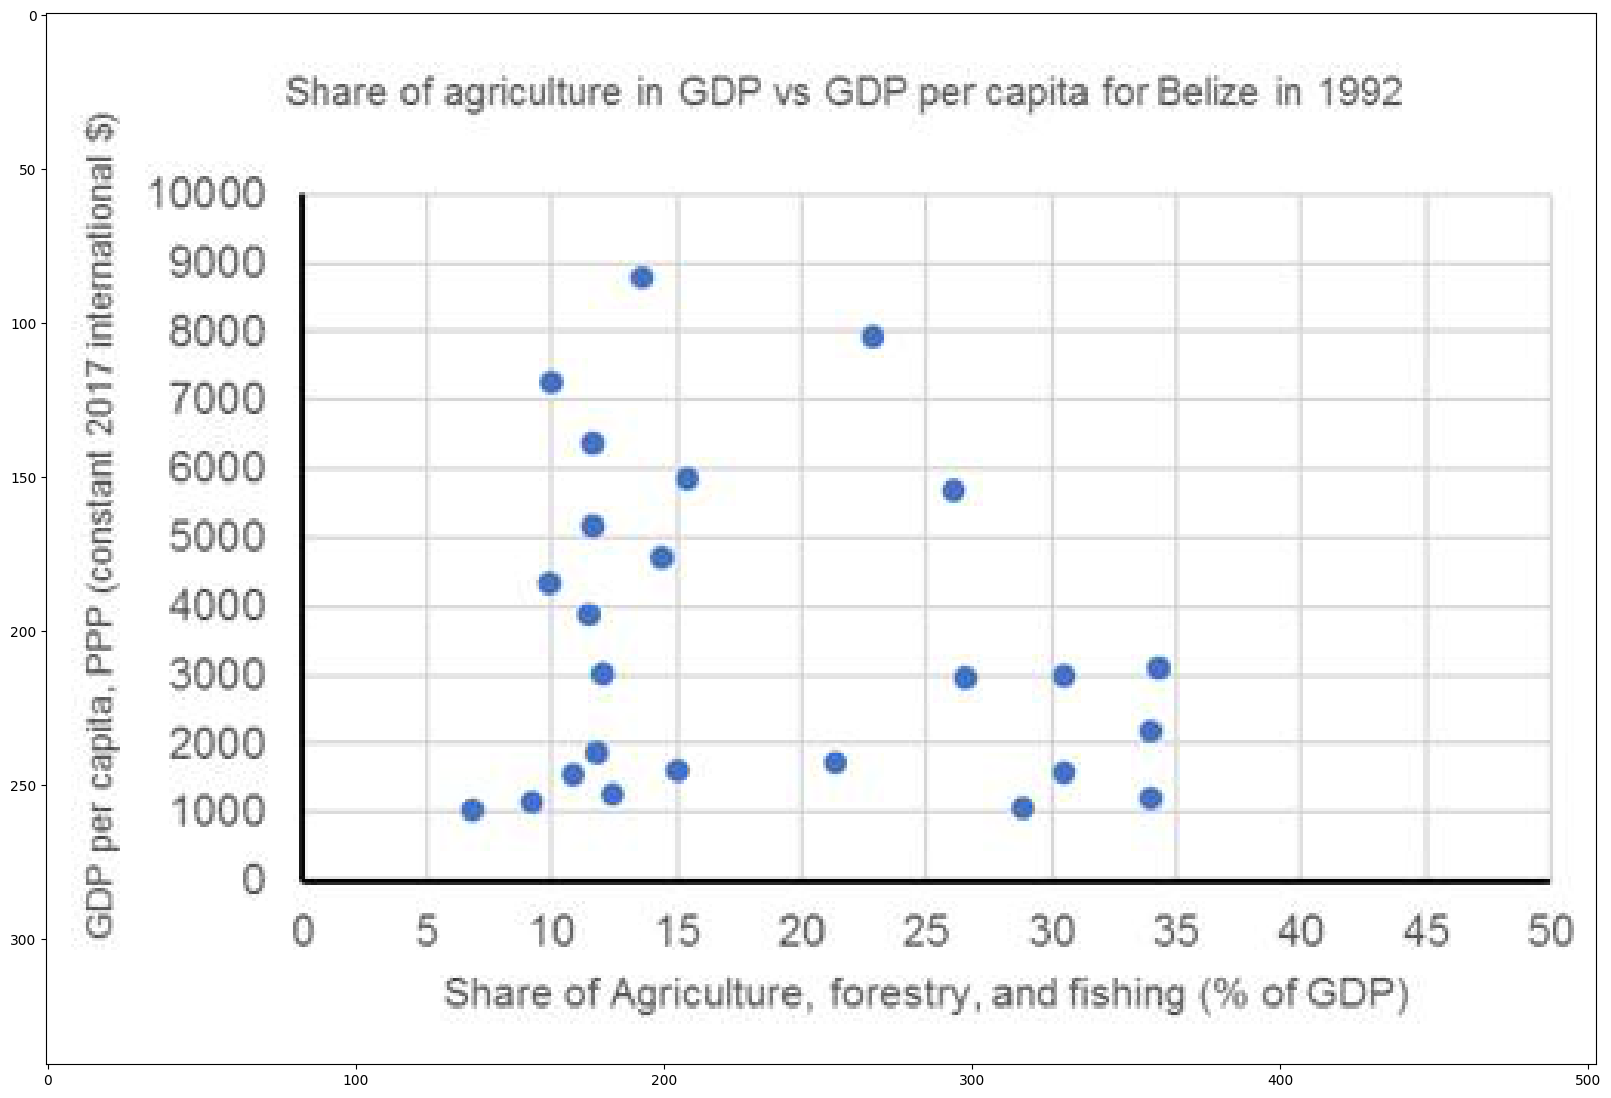

In [11]:
#f6811313336b
image_file = "dataset/train/images/{}.jpg".format("ff5faac302bf")
image = Image.open(image_file)
plt.rcParams["figure.figsize"] = (20,15)
plt.imshow(image)
plt.show()

**Create dataset**

In [12]:
def get_gt_string_and_xy(filepath: Union[str, os.PathLike]) -> Dict[str, str]:
    filename = str(filepath).split('/')[-1][:-5]
    if len(df[df['image_id'] == filename]) == 0:
       return None
    for tup in df[df['image_id'] == filename].groupby("image_id"):
        name = tup[0]
        chart_title = None
        x_axis_title = None
        y_axis_title = None
        source = None
        x_tick = []
        y_tick = []
        for ele in tup:
            try:
              chart_title = ele[ele['label'] == 'chart_title']['text'].to_list()[0]
              x_axis_title = ele[ele['label'] == 'x_axis_title']['text'].to_list()[0]
              y_axis_title = ele[ele['label'] == 'y_axis_title']['text'].to_list()[0]
              x_tick = ele[ele['label'] == 'x_tick_label']['text'].to_list()
              y_tick = ele[ele['label'] == 'y_tick_label']['text'].to_list()
              source = ele["source"].to_list()[0]
              # print(chart_title)
              # print(x_axis_title)
              # print(y_axis_title)
              # print(x_tick)
              # print(y_tick)
            except:
              continue
        try:
          if chart_title is None: chart_str = CHART_TITLE_START + '' + CHART_TITLE_END
          else: chart_str = CHART_TITLE_START + chart_title + CHART_TITLE_END
          if x_axis_title is None: x_axis_str = AXIS_TITLE_X_START + '' + AXIS_TITLE_X_END
          else: x_axis_str = AXIS_TITLE_X_START + x_axis_title + AXIS_TITLE_X_END
          if y_axis_title is None: y_axis_str = AXIS_TITLE_Y_START + '' + AXIS_TITLE_Y_END
          else: y_axis_str = AXIS_TITLE_Y_START + y_axis_title + AXIS_TITLE_Y_END
          x_tick_str = TICK_LABEL_X_START + ";".join(list(map(str, x_tick))) + TICK_LABEL_X_END
          y_tick_str = TICK_LABEL_Y_START + ";".join(list(map(str, y_tick))) + TICK_LABEL_Y_END
          gt_string = PROMPT_TOKEN + chart_str + x_axis_str + y_axis_str + x_tick_str + y_tick_str + PROMPT_END_TOKEN
          dict_res = {
              "ground_truth": gt_string,
              "x_axis_title": x_axis_title,
              "y_axis_title": y_axis_title,
              "x": json.dumps(x_tick),
              "y": json.dumps(y_tick),
              "id" : name,
              "source" : source
          }
          return dict_res
        except:
          print(name)
          assert(print("error"))

In [13]:
get_gt_string_and_xy(data_dir / "annotations" / "d0a34b91c857.json")

{'ground_truth': '<|PROMPT|><chart_title_start>Share of agriculture in GDP vs GDP per capita Benin in 2017<chart_title_end><axis_title_x_start>Share of Agriculture, forestry, and fishing (% of GDP)<axis_title_x_end><axis_title_y_start>GDP per capita, PPP (constant 2017 international $)<axis_title_y_end><tick_label_x_start>0;5;10;15;20;25;30;35;40;45;50<tick_label_x_end><tick_label_y_start>8000;7000;6000;5000;4000;3000;2000;1000;0<tick_label_y_end></|PROMPT|>',
 'x_axis_title': 'Share of Agriculture, forestry, and fishing (% of GDP)',
 'y_axis_title': 'GDP per capita, PPP (constant 2017 international $)',
 'x': '["0", "5", "10", "15", "20", "25", "30", "35", "40", "45", "50"]',
 'y': '["8000", "7000", "6000", "5000", "4000", "3000", "2000", "1000", "0"]',
 'id': 'd0a34b91c857',
 'source': 'generated'}

In [14]:
df[df['image_id'] == "f6811313336b"]

,image_id,source,chart,label,text
203301,f6811313336b,extracted,scatter,y_axis_title,Math Mark Increase (%)
203302,f6811313336b,extracted,scatter,x_axis_title,Hours Spent Studying
203303,f6811313336b,extracted,scatter,x_tick_label,1
203304,f6811313336b,extracted,scatter,x_tick_label,2
203305,f6811313336b,extracted,scatter,x_tick_label,3
203306,f6811313336b,extracted,scatter,x_tick_label,4
203307,f6811313336b,extracted,scatter,x_tick_label,5
203308,f6811313336b,extracted,scatter,x_tick_label,6
203309,f6811313336b,extracted,scatter,x_tick_label,7
203310,f6811313336b,extracted,scatter,y_tick_label,6


In [15]:
def gen_data(files: List[Union[str, os.PathLike]]) -> Dict[str, str]:
    for f in files:
        res = get_gt_string_and_xy(f)
        if res is None:
           continue
        yield {
            **res,
            "image_path": str(images_path / f"{f.stem}.jpg"),
        }


ds = Dataset.from_generator(
    gen_data, gen_kwargs={"files": train_json_files}, num_proc=CFG.num_proc
)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset generator downloaded and prepared to /root/.cache/huggingface/datasets/generator/default-c25465f7765743e2/0.0.0. Subsequent calls will reuse this data.


In [16]:
ds

Dataset({
    features: ['ground_truth', 'x_axis_title', 'y_axis_title', 'x', 'y', 'id', 'source', 'image_path'],
    num_rows: 11243
})

In [17]:
def add_image_sizes(examples: Dict[str, Union[str, os.PathLike]]) -> Dict[str, List[int]]:
    sizes = [Image.open(x).size for x in examples["image_path"]]

    width, height = list(zip(*sizes))

    return {
        "width": list(width),
        "height": list(height),
    }


ds = ds.map(add_image_sizes, batched=True, num_proc=CFG.num_proc)

Map (num_proc=2):   0%|          | 0/11243 [00:00<?, ? examples/s]

**Model Configuration**

In [18]:
config = VisionEncoderDecoderConfig.from_pretrained("naver-clova-ix/donut-base")
config.encoder.image_size = (CFG.image_height, CFG.image_width)
config.decoder.max_length = CFG.max_length

print(CFG.image_height, CFG.image_width, CFG.max_length)

560 560 1024


In [19]:
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
processor.image_processor.size = {
    "height": CFG.image_height,
    "width": CFG.image_width,
}

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


**Unk Word**

In [20]:
def check_for_unk(examples: Dict[str, str]) -> Dict[str, List[str]]:
    texts = examples["ground_truth"]
    ids = processor.tokenizer(texts).input_ids
    tokens = [processor.tokenizer.tokenize(x, add_special_tokens=True) for x in texts]

    unk_tokens = []
    for example_ids, example_tokens in zip(ids, tokens):
        example_unk_tokens = []
        for i in range(len(example_ids)):
            if example_ids[i] == processor.tokenizer.unk_token_id:
                example_unk_tokens.append(example_tokens[i])

        unk_tokens.append(example_unk_tokens)

    return {"unk_tokens": unk_tokens}


unk = ds.map(check_for_unk, batched=True, num_proc=CFG.num_proc)

Map (num_proc=2):   0%|          | 0/11243 [00:00<?, ? examples/s]

In [21]:
unk = unk.filter(lambda x: len(x["unk_tokens"]) > 0, num_proc=CFG.num_proc)

print(len(unk))

Filter (num_proc=2):   0%|          | 0/11243 [00:00<?, ? examples/s]

742


In [22]:
all_unk_tokens = [x for y in unk["unk_tokens"] for x in y]

Counter(all_unk_tokens)

Counter({'1': 836, 'Ã©': 1})

In [23]:
example_str = "0.1 1 1990"

temp_ids = processor.tokenizer(example_str).input_ids
print("ids:", temp_ids)
print("tokenized:", processor.tokenizer.tokenize(example_str))
print("decoded:", processor.tokenizer.decode(temp_ids))
print("unk id:", processor.tokenizer.unk_token_id)

# Adding these tokens should mean that there should be very few unknown tokens
num_added = processor.tokenizer.add_tokens(["<one>"] + new_tokens)
print(num_added, "tokens added")

config.pad_token_id = processor.tokenizer.pad_token_id

ids: [0, 50891, 39539, 3, 1314, 4314, 2]
tokenized: ['▁0', '.', '1', '▁1', '▁1990']
decoded: <s> 0.<unk> 1 1990</s>
unk id: 3
13 tokens added


In [24]:
config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids([PROMPT_TOKEN])[0]

In [25]:
config.decoder_end_token_id = processor.tokenizer.convert_tokens_to_ids([PROMPT_END_TOKEN])[0]

In [26]:
print("Pad token ID:", processor.decode([config.pad_token_id]))
print("Decoder start token ID:", processor.decode([config.decoder_start_token_id]))
print("Decoder end token ID:", processor.decode([config.decoder_end_token_id]))

Pad token ID: <pad>
Decoder start token ID: <|PROMPT|>
Decoder end token ID: </|PROMPT|>


**Replace one token**

In [27]:
from functools import partial

one_token_id = processor.tokenizer("<one>", add_special_tokens=False).input_ids[0]
unk_token_id = processor.tokenizer.unk_token_id

def replace_unk_tokens_with_one(example_ids: List[int], example_tokens: List[str], one_token_id:int, unk_token_id:int) -> List[int]:
    temp_ids = []
    for id_, token in zip(example_ids, example_tokens):
        if id_ == unk_token_id and token == "1":
            id_ = one_token_id
        temp_ids.append(id_)
    return temp_ids

def preprocess(examples: Dict[str, str], processor: DonutProcessor, CFG: CFG) -> Dict[str, Union[torch.Tensor, List[int], List[str]]]:
    pixel_values = []

    texts = examples["ground_truth"]

    ids = processor.tokenizer(
        texts,
        add_special_tokens=False,
        max_length=CFG.max_length,
        padding=True,
        truncation=True,
    ).input_ids

    if isinstance(texts, str):
        texts = [texts]

    tokens = [processor.tokenizer.tokenize(text, add_special_tokens=False) for text in texts]
    
    one_token_id = processor.tokenizer("<one>", add_special_tokens=False).input_ids[0]
    unk_token_id = processor.tokenizer.unk_token_id
    
    final_ids = [
        replace_unk_tokens_with_one(example_ids, example_tokens, one_token_id, unk_token_id)
        for example_ids, example_tokens in zip(ids, tokens)
    ]

    for sample in examples["image_path"]:
        pixel_values.append(processor(sample, random_padding=True).pixel_values)

    return {
        "pixel_values": torch.tensor(np.vstack(pixel_values)),
        "input_ids": final_ids,
        "id": examples["id"],
        "answers" : texts
    }

In [28]:
image_ds = ds.cast_column("image_path", ds_img())
image_ds.set_transform(partial(preprocess, processor=processor, CFG=CFG))

In [29]:
sample = image_ds[[0, 1, 2]]

print(sample["pixel_values"].shape)
print(processor.decode(sample["input_ids"][2]))
print(len(sample["input_ids"][2]))
print(processor.tokenizer.convert_ids_to_tokens(sample["input_ids"][2]))

torch.Size([3, 3, 560, 560])
<|PROMPT|><chart_title_start> Inflation during the year Israel<chart_title_end><axis_title_x_start> Years<axis_title_x_end><axis_title_y_start> Consumer price index<axis_title_y_end><tick_label_x_start> 1950;1960;1970;1980;1990;2000;2010;2020<tick_label_x_end><tick_label_y_start> 350.00;300.00;250.00;200.00;150.00;100.00;0;50.00<tick_label_y_end></|PROMPT|>
63
['<|PROMPT|>', '<chart_title_start>', '▁Inf', 'lation', '▁during', '▁the', '▁year', '▁Israel', '<chart_title_end>', '<axis_title_x_start>', '▁Year', 's', '<axis_title_x_end>', '<axis_title_y_start>', '▁Consum', 'er', '▁price', '▁index', '<axis_title_y_end>', '<tick_label_x_start>', '▁1950', ';', '19', '60', ';', '19', '70', ';', '1980', ';', '1990', ';', '2000', ';', '2010', ';', '2020', '<tick_label_x_end>', '<tick_label_y_start>', '▁35', '0.00', ';', '30', '0.00', ';', '25', '0.00', ';', '20', '0.00', ';', '15', '0.00', ';', '10', '0.00', ';', '0', ';', '5', '0.00', '<tick_label_y_end>', '</|PROMPT|

In [30]:
len(ds)
train_len = int(len(ds) * 0.9)
test_len = int(len(ds) * 0.95)
val_len = int(len(ds))
train_ds = ds.select(*[range(0,train_len)])
train_ds = train_ds.cast_column("image_path", ds_img())
train_ds.set_transform(partial(preprocess, processor=processor, CFG=CFG))

test_ds = ds.select(*[range(train_len,test_len)])
test_ds = test_ds.cast_column("image_path", ds_img())
test_ds.set_transform(partial(preprocess, processor=processor, CFG=CFG))

val_ds = ds.select(*[range(test_len,val_len)])
val_ds = val_ds.cast_column("image_path", ds_img())
val_ds.set_transform(partial(preprocess, processor=processor, CFG=CFG))

In [31]:
next(iter(train_ds))

{'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 'input_ids': [57526,
  57527,
  37526,
  40920,
  56434,
  38860,

In [32]:
#collate function
pad_token_id = processor.tokenizer.pad_token_id

def collate_fn(samples: List[Dict[str, Union[torch.Tensor, List[int], str]]]) -> Dict[str, Union[torch.Tensor, List[str]]]:
    batch = {}

    batch["pixel_values"] = torch.stack([x["pixel_values"] for x in samples])

    max_length = max([len(x["input_ids"]) for x in samples])

    # Make a multiple of 8 to efficiently use the tensor cores
    if max_length % 8 != 0:
        max_length = (max_length // 8 + 1) * 8

    input_ids = [
        x["input_ids"] + [pad_token_id] * (max_length - len(x["input_ids"]))
        for x in samples
    ]

    labels = torch.tensor(input_ids)
    labels[labels == pad_token_id] = -100 # ignore loss on padding tokens
    batch["labels"] = labels
    
    batch["id"] = [x["id"] for x in samples]
    batch["answers"] = [x["answers"] for x in samples]
    return batch

In [33]:
if CFG.debug:
    train_ds = train_ds.select(range(100))
    val_ds = val_ds.select(range(100))

train_dataloader = DataLoader(
    train_ds,
    batch_size=CFG.batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=CFG.num_workers,
)
val_dataloader = DataLoader(
    val_ds,
    batch_size=CFG.batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=CFG.num_workers,
)

test_dataloader = DataLoader(
    test_ds,
    batch_size=CFG.batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=CFG.num_workers,
)



num_training_steps = len(train_dataloader) * CFG.epochs // CFG.gpus

batch = next(iter(train_dataloader))

batch.keys(), [(k, v.shape) for k, v in batch.items() if k != "id" and k != "answers"]

(dict_keys(['pixel_values', 'labels', 'id', 'answers']),
 [('pixel_values', torch.Size([2, 3, 560, 560])),
  ('labels', torch.Size([2, 112]))])

**Lightning Model**

In [34]:
model = VisionEncoderDecoderModel.from_pretrained(
    "naver-clova-ix/donut-base", config=config
)
model.decoder.resize_token_embeddings(len(processor.tokenizer))

Embedding(57538, 1024)

In [35]:
import pytorch_lightning as pl
from transformers import PreTrainedTokenizerBase, PreTrainedModel
from nltk import edit_distance

class DonutModelPLModule(pl.LightningModule):
    def __init__(self, processor, model):
        """
        A PyTorch Lightning module for the DonutModel.

        Args:
            processor (PreTrainedTokenizerBase): The tokenizer/processor for the model.
            model (PreTrainedModel): The pretrained model.
            gt_df (pd.DataFrame): The ground truth dataframe.
            num_training_steps (int): The number of training steps.
        """
        super().__init__()
        self.processor = processor
        self.model = model
        self.idx = 0

    def training_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> torch.Tensor:
        self.idx = 0
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]

        outputs = self.model(pixel_values, labels=labels)
        loss = outputs.loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch: Dict[str, torch.Tensor], batch_idx: int, dataset_idx: int = 0) -> None:
        if self.idx == 10:
           return
        # pixel_values, labels, answers = batch
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]
        answers = batch["answers"]
        # print(pixel_values)
        batch_size = pixel_values.shape[0]
        # we feed the prompt to the model
        decoder_input_ids = torch.full(
            (batch_size, 1),
            self.model.config.decoder_start_token_id,
            device=self.device,
        )

        outputs = self.model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=CFG.max_length,
            early_stopping=True,
            pad_token_id=self.processor.tokenizer.pad_token_id,
            eos_token_id=self.processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            top_k=1,
            bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

        predictions = []
        for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
            seq = seq.replace(processor.decode([self.model.config.decoder_end_token_id]), "").replace(self.processor.tokenizer.pad_token, "").replace(self.processor.tokenizer.eos_token,"")
            seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            predictions.append(seq)

        scores = []
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"<one>", "1", pred)
            pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
            pred = pred.split('<tick_label_y_end>')[0] + '<tick_label_y_end>'
            # NOT NEEDED ANYMORE
            # answer = re.sub(r"<.*?>", "", answer, count=1)
            answer = answer.replace(processor.decode([self.model.config.decoder_end_token_id]), "").replace(self.processor.tokenizer.eos_token,"")
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores))
        self.idx += 1


    def configure_optimizers(self) -> torch.optim.Optimizer:
        
        optimizer = torch.optim.Adam(self.parameters(), lr=CFG.lr)

        return optimizer
    
    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

In [36]:
model_module = DonutModelPLModule(processor, model)

**training**

In [37]:
import locale 
print(locale.getdefaultlocale())
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
print(locale.getpreferredencoding())

('en_US', 'UTF-8')
UTF-8


In [38]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as d

In [39]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback, EarlyStopping

wandb_logger = WandbLogger(project="DonutAxis", name="demo-run-donut")

class PushToHubCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Pushing model to the hub, epoch {trainer.current_epoch}")
        pl_module.model.push_to_hub("hoangphu7122002ai/donutAxis_v1",
                                    commit_message=f"Training in progress, epoch {trainer.current_epoch}")
        pl_module.processor.push_to_hub("hoangphu7122002ai/donutAxis_v1",
                                    commit_message=f"Training in progress, epoch {trainer.current_epoch}")

    def on_train_end(self, trainer, pl_module):
        print(f"Pushing model to the hub after training")
        pl_module.processor.push_to_hub("hoangphu7122002ai/donutAxis_v1",
                                    commit_message=f"Training done")
        pl_module.model.push_to_hub("hoangphu7122002ai/donutAxis_v1",
                                    commit_message=f"Training done")

early_stop_callback = EarlyStopping(monitor="val_edit_distance", patience=3, verbose=False, mode="min")

trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=CFG.epochs,
        val_check_interval=CFG.val_check_interval,
        check_val_every_n_epoch=CFG.check_val_every_n_epoch,
        gradient_clip_val=CFG.gradient_clip_val,
        precision=16, # if you have tensor cores (t4, v100, a100, etc.) training will be 2x faster
        num_sanity_val_steps=5,
        callbacks=[PushToHubCallback()], 
        logger=wandb_logger,
)


trainer.fit(model_module, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                      | Params
---------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

Prediction: <tick_label_y_end>
    Answer: <|PROMPT|><chart_title_start>Tea Crops Production in Mauritius<chart_title_end><axis_title_x_start>Years<axis_title_x_end><axis_title_y_start>Production in tonnes<axis_title_y_end><tick_label_x_start>1950;1960;1970;1980;1990;2000;2010;2020;2030<tick_label_x_end><tick_label_y_start>8000;7000;6000;5000;4000;3000;2000;1000;0<tick_label_y_end>
 Normed ED: 0.9472140762463344


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Prediction: <tick_label_y_end>
    Answer: <|PROMPT|><chart_title_start>Agricultural index in Eswatini<chart_title_end><axis_title_x_start>Years<axis_title_x_end><axis_title_y_start>Agricultural index<axis_title_y_end><tick_label_x_start>1950;1960;1970;1980;1990;2000;2010;2020;2030<tick_label_x_end><tick_label_y_start>120.0;100.0;80.0;60.0;40.0;20.0;0.0<tick_label_y_end>
 Normed ED: 0.9454545454545454
Prediction: <tick_label_y_end>
    Answer: <|PROMPT|><chart_title_start>Deaths - Malaria - Sex: Both - Age: 70+ years in Madagascar<chart_title_end><axis_title_x_start>Years<axis_title_x_end><axis_title_y_start>No of Deaths by Malaria<axis_title_y_end><tick_label_x_start>1985;1990;1995;2000;2005;2010;2015;2020;2025<tick_label_x_end><tick_label_y_start>600;500;400;300;200;100;0<tick_label_y_end>
 Normed ED: 0.9491525423728814
Prediction: <tick_label_y_end>
    Answer: <|PROMPT|><chart_title_start>Daliy Bio-degradeable waste produced in United Arab Emirates<chart_title_end><axis_title_x_sta

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Prediction: <|PROMPT|><chart_title_start>Tea Crops Production in Mauritius<chart_title_end><axis_title_x_start>Years<axis_title_x_end><axis_title_y_start>Producion in tonnes<axis_title_y_end><tick_label_x_start>1950;1960;1970;1980;1990;2000;2010;2020;2030<tick_label_x_end><tick_label_y_start>8000;7000;6000;5000;4000;3000;2000;1000;0<tick_label_y_end>
    Answer: <|PROMPT|><chart_title_start>Tea Crops Production in Mauritius<chart_title_end><axis_title_x_start>Years<axis_title_x_end><axis_title_y_start>Production in tonnes<axis_title_y_end><tick_label_x_start>1950;1960;1970;1980;1990;2000;2010;2020;2030<tick_label_x_end><tick_label_y_start>8000;7000;6000;5000;4000;3000;2000;1000;0<tick_label_y_end>
 Normed ED: 0.002932551319648094
Prediction: <|PROMPT|><chart_title_start>Agricultural index in Eswatini<chart_title_end><axis_title_x_start>Years<axis_title_x_end><axis_title_y_start>Agricultural index<axis_title_y_end><tick_label_x_start>1950;1960;1970;1980;1990;2000;2010;2020;2030<tick_lab

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: 0it [00:00, ?it/s]

Prediction: <|PROMPT|><chart_title_start>Tea Crops Production in Mauritius<chart_title_end><axis_title_x_start>Years<axis_title_x_end><axis_title_y_start>Producion in tonnes<axis_title_y_end><tick_label_x_start>1950;1960;1970;1980;1990;2000;2010;2020;2030<tick_label_x_end><tick_label_y_start>8000;7000;6000;5000;4000;3000;2000;1000;0<tick_label_y_end>
    Answer: <|PROMPT|><chart_title_start>Tea Crops Production in Mauritius<chart_title_end><axis_title_x_start>Years<axis_title_x_end><axis_title_y_start>Production in tonnes<axis_title_y_end><tick_label_x_start>1950;1960;1970;1980;1990;2000;2010;2020;2030<tick_label_x_end><tick_label_y_start>8000;7000;6000;5000;4000;3000;2000;1000;0<tick_label_y_end>
 Normed ED: 0.002932551319648094
Prediction: <|PROMPT|><chart_title_start>Agricultural index in Eswatini<chart_title_end><axis_title_x_start>Years<axis_title_x_end><axis_title_y_start>Agricultural index<axis_title_y_end><tick_label_x_start>1950;1960;1970;1980;1990;2000;2010;2020;2030<tick_lab

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Pushing model to the hub after training


In [40]:
model_module.processor.push_to_hub("hoangphu7122002ai/donutAxis_v1",
                                    commit_message=f"test")
model_module.model.push_to_hub("hoangphu7122002ai/donutAxis_v1",
                                    commit_message=f"test")

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/hoangphu7122002ai/donutAxis_v1/commit/8778ab5f5369fd827cb74a811486ac6918cc4a86', commit_message='test', commit_description='', oid='8778ab5f5369fd827cb74a811486ac6918cc4a86', pr_url=None, pr_revision=None, pr_num=None)